In [1]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import numpy as np
# 변환 활성화
pandas2ri.activate()

def import_r_data():
    # 1) 필수 패키지 로드
    ro.r('library(haven)')
    # 2) R-side 데이터 로드
    ro.r('fish <- read_dta("http://www.stata-press.com/data/r11/fish.dta")')
    # 3) Python으로 변환
    fish_df = pandas2ri.rpy2py(ro.r('fish'))
    return fish_df

# 사용 예
fish = import_r_data()
print(type(fish))   # pandas.DataFrame
print(fish.head())

! curl package not installed, falling back to using `url()`
<class 'pandas.core.frame.DataFrame'>
   nofish  livebait  camper  persons  child        xb        zg  count
1     1.0       0.0     0.0      1.0    0.0 -0.896315  3.050405    0.0
2     0.0       1.0     1.0      1.0    0.0 -0.558345  1.746149    0.0
3     0.0       1.0     0.0      1.0    0.0 -0.401731  0.279939    0.0
4     0.0       1.0     1.0      2.0    1.0 -0.956298 -0.601526    0.0
5     0.0       1.0     0.0      1.0    0.0  0.436891  0.527709    1.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import poisson
from scipy.special import gammaln

# --- 0) fish.csv에서 공변량 로드 + multimodal y 생성 ---
n_fish = len(fish)

# fish 모드: 실제 fish count, persons, camper 사용
y_fish = fish['count'].values.astype(int)
X_fish = np.column_stack([np.ones(n_fish), fish[['persons']].values])
Z_fish = np.column_stack([np.ones(n_fish), fish[['camper']].values])

# Poisson(10) 모드: synthetic 데이터, 공변량은 더미(0)로 설정
np.random.seed(42)
n_p10 = n_fish
y_p10 = np.random.poisson(lam=10, size=n_p10)
X_p10 = np.column_stack([np.ones(n_p10), np.zeros((n_p10, 1))])  # persons=0
Z_p10 = np.column_stack([np.ones(n_p10), np.zeros((n_p10, 1))])  # camper=0

# 결합
y_comb = np.concatenate([y_fish, y_p10])
X_comb = np.vstack([X_fish, X_p10])
Z_comb = np.vstack([Z_fish, Z_p10])
N = len(y_comb)


===== SOS-ZIPAP 학습: degree = 0 =====
  Trial  1: logLik = -1455.210060
  Trial  2: logLik = -1455.210060
  Trial  3: logLik = -1455.210060
  Trial  4: logLik = -1455.210060
  Trial  5: logLik = -1455.210060
  ★ Best logLik = -1455.210060
    α (degree=0): [1.]

===== SOS-ZIPAP 학습: degree = 1 =====
  Trial  1: logLik = -1455.210060
  Trial  2: logLik = -1455.210060
  Trial  3: logLik = -1455.210060
  Trial  4: logLik = -1455.210060
  Trial  5: logLik = -1455.210060
  ★ Best logLik = -1455.210060
    α (degree=1): [1. 0.]

===== SOS-ZIPAP 학습: degree = 2 =====
  Trial  1: logLik = -1455.210060
  Trial  2: logLik = -1455.210060
  Trial  3: logLik = -1455.210060
  Trial  4: logLik = -1455.210060
  Trial  5: logLik = -1455.210060
  ★ Best logLik = -1455.210060
    α (degree=2): [1. 0. 0.]

===== SOS-ZIPAP 학습: degree = 3 =====
  Trial  1: logLik = -1345.945249
  Trial  2: logLik = -1345.945249
  Trial  3: logLik = -1345.945249
  Trial  4: logLik = -1345.945249
  Trial  5: logLik = -1345.9452

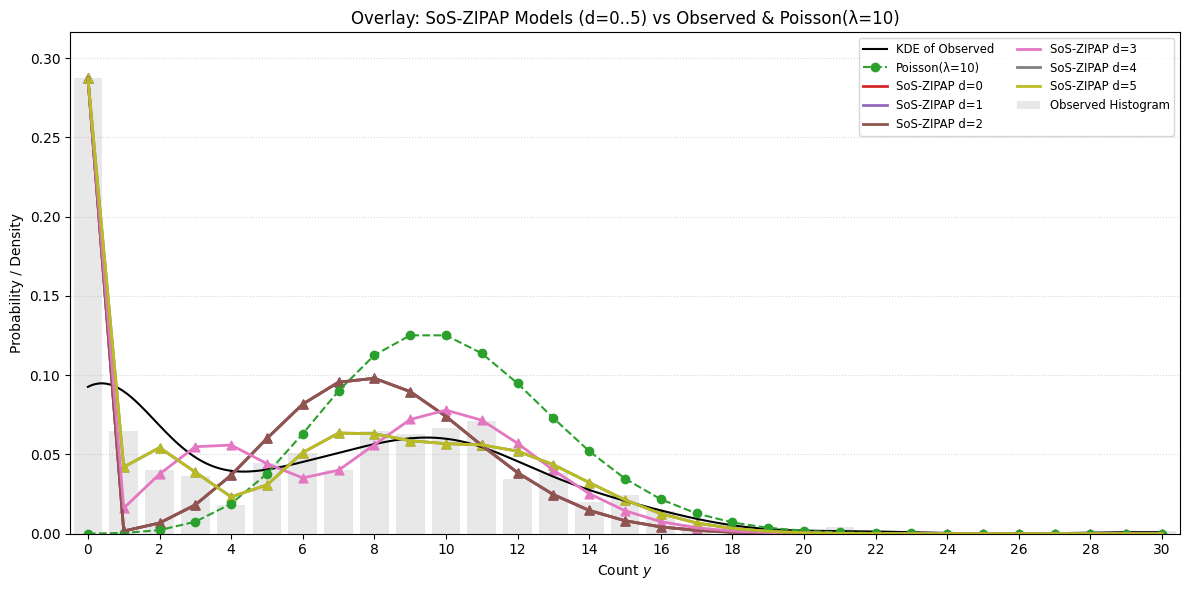

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson, gaussian_kde
from functools import lru_cache

# ============================================================
# 1) 데이터 로드 및 준비
# ============================================================
y_fish     = fish["count"].astype(int).values
X_fish_raw = fish[["persons"]].values.astype(float)
Z_fish_raw = fish[["camper"] ].values.astype(float)

# Poisson(λ=10) 합성
np.random.seed(42)
n_fish = len(y_fish)
y_p10  = np.random.poisson(lam=10, size=n_fish)
X_p10_raw = np.random.choice(X_fish_raw.flatten(), size=n_fish).reshape(-1,1)
Z_p10_raw = np.random.choice(Z_fish_raw.flatten(), size=n_fish).reshape(-1,1)

# 관측 + 합성 데이터 결합 후 y ≤ 30 필터

y_comb = np.concatenate([y_fish, y_p10])
X_comb = np.vstack([X_fish_raw, X_p10_raw])
Z_comb = np.vstack([Z_fish_raw, Z_p10_raw])

mask = y_comb <= 30
y_all = y_comb[mask]
X_all = X_comb[mask]
Z_all = Z_comb[mask]

# 디자인 행렬: λ 모델용(X), π 모델용(Z)
X = np.column_stack([np.ones_like(y_all), X_all])  # (N,2): [1, persons]
Z = np.column_stack([np.ones_like(y_all), Z_all])  # (N,2): [1, camper]

n = len(y_all)  # 표본 크기

# ============================================================
# 2) Poisson raw-moment 계산 함수 (Stirling 수 재귀)
# ============================================================
@lru_cache(None)
def _S(n, k):
    if n == k == 0:
        return 1
    if n == 0 or k == 0 or k > n:
        return 0
    return _S(n-1, k-1) + k * _S(n-1, k)

def poisson_raw_moment(j, lam):
    """
    μ_j(λ) = E[Y^j] for Y ~ Pois(λ), lam이 배열이어도 지원.
    j=0..5에 대해서는 closed-form, 그 이상은 Stirling 수로 계산.
    """
    lam = np.asarray(lam, dtype=float)
    if j == 0:
        return np.ones_like(lam)
    if j == 1:
        return lam
    if j == 2:
        return lam**2 + lam
    if j == 3:
        return lam**3 + 3*lam**2 + lam
    if j == 4:
        return lam**4 + 6*lam**3 + 7*lam**2 + lam
    if j == 5:
        return lam**5 + 10*lam**4 + 25*lam**3 + 15*lam**2 + lam
    out = np.zeros_like(lam)
    for k in range(j+1):
        out += _S(j, k) * lam**k
    return out

# ============================================================
# 3) u, v → α 벡터 계산 함수 (SOS 전개)
# ============================================================
def compute_alpha_from_uv(u, v):
    """
    u[0]=1 고정.   s0(y)=Σ u_i y^i, s1(y)=Σ v_i y^i
    T(y) = s0(y)^2 + y·(s1(y))^2 → α_j (j=0..d)
    """
    r0, r1 = len(u)-1, len(v)-1
    d = max(2*r0, 1 + 2*r1)
    α = np.zeros(d+1)
    α[0] = 1.0
    # s0(y)^2 부분
    for i in range(r0+1):
        for j in range(r0+1):
            if i == 0 and j == 0:
                continue
            α[i+j] += u[i] * u[j]
    # y·s1(y)^2 부분
    for p in range(r1+1):
        for q in range(r1+1):
            α[p+q+1] += v[p] * v[q]
    return α

# ============================================================
# 4) SOS-ZIPAP 클래스 정의 (degree d)
# ============================================================
class ZIPAP_SoS_ID:
    def __init__(self, X, Z, degree: int):
        self.X = np.asarray(X)
        self.Z = np.asarray(Z)
        if self.X.ndim == 1:
            self.X = self.X[:, None]
        if self.Z.ndim == 1:
            self.Z = self.Z[:, None]
        self.n, self.p = self.X.shape
        _,    self.q = self.Z.shape
        self.d = degree
        self.r0 = degree // 2
        self.r1 = (degree - 1) // 2
        # θ = [β (p개), γ (q개), u1..u_r0 (r0개), v0..v_r1 (r1+1개)]
        self.theta = np.zeros(self.p + self.q + self.r0 + (self.r1 + 1))

    def _unpack(self, θ):
        β = θ[:self.p]
        γ = θ[self.p : self.p + self.q]
        ptr = self.p + self.q
        u1 = θ[ptr : ptr + self.r0]                     # u₁..u_{r0}
        v  = θ[ptr + self.r0 : ptr + self.r0 + (self.r1 + 1)]
        u = np.concatenate(([1.0], u1))  # u[0] = 1.0 고정
        return β, γ, u, v

    def _T(self, y, u, v):
        y = np.asarray(y, dtype=float)
        s0 = np.zeros_like(y, dtype=float)
        for k in range(len(u)):
            s0 += u[k] * (y**k)
        Tval = s0**2
        if len(v) > 0:
            s1 = np.zeros_like(y, dtype=float)
            for k in range(len(v)):
                s1 += v[k] * (y**k)
            Tval += y * (s1**2)
        return Tval

    def _Z(self, lam, u, v):
        α = compute_alpha_from_uv(u, v)
        Zval = 0.0
        for j, αj in enumerate(α):
            Zval += αj * poisson_raw_moment(j, lam)
        return Zval

    def neg_loglik(self, θ, y):
        β, γ, u, v = self._unpack(θ)
        lam_vec = np.exp(self.X @ β)                    # (n,)
        pi_vec  = 1.0 / (1.0 + np.exp(-(self.Z @ γ)))    # (n,)
        T_y     = self._T(y, u, v)                      # (n,)
        Zvals   = np.array([self._Z(li, u, v) for li in lam_vec])  # (n,)
        if np.any(Zvals <= 0) or np.any(~np.isfinite(Zvals)):
            return 1e10
        Pstar   = T_y * poisson.pmf(y, lam_vec) / Zvals
        prob    = np.where(
            y == 0,
            pi_vec + (1.0 - pi_vec) * Pstar,
            (1.0 - pi_vec) * Pstar
        )
        if np.any(prob <= 0) or np.any(~np.isfinite(prob)):
            return 1e10
        return -np.sum(np.log(prob))

    def fit(self, y, maxiter=3000):
        y = np.asarray(y)
        n0 = (y == 0).sum()
        denom = len(y) - n0

        # β₀ 초기값: log(mean(y[y>0]))
        β0 = np.zeros(self.p)
        if np.any(y > 0):
            β0[0] = np.log(np.mean(y[y > 0]))

        # γ₀ 초기값: log((n0+ε)/(n−n0))
        γ0 = np.zeros(self.q)
        if denom > 0:
            γ0[0] = np.log((n0 + 1e-8) / denom)

        u1_init = np.zeros(self.r0)      # u₁..u_{r0} = 0
        v_init  = np.zeros(self.r1 + 1)  # v₀..v_{r1} = 0
        θ0 = np.concatenate([β0, γ0, u1_init, v_init])

        res = minimize(self.neg_loglik, θ0, args=(y,),
                       method="L-BFGS-B", options={"maxiter": maxiter})
        if not res.success:
            raise RuntimeError(f"Optimization failed: {res.message}")

        self.theta = res.x
        return res

    def get_params(self):
        β, γ, u, v = self._unpack(self.theta)
        lam_vec = np.exp(self.X @ β)
        pi_vec  = 1.0 / (1.0 + np.exp(-(self.Z @ γ)))
        return β, γ, u, v, lam_vec, pi_vec

# ============================================================
# 5) degree = 0 ~ 5 모델 학습 & 결과 저장
# ============================================================
best_results = []

# 멀티 스타트 전략
for d in range(6):  # degree = 0,1,2,3,4,5
    print(f"\n===== SOS-ZIPAP 학습: degree = {d} =====")
    best_ll, best_mdl, best_res = -np.inf, None, None

    for trial in range(1, 6):
        mdl = ZIPAP_SoS_ID(X, Z, degree=d)
        try:
            res = mdl.fit(y_all)
        except Exception as e:
            print(f"  Trial {trial:2d} 실패: {e}")
            continue

        ll = -mdl.neg_loglik(mdl.theta, y_all)
        print(f"  Trial {trial:2d}: logLik = {ll:.6f}")
        if ll > best_ll:
            best_ll = ll
            best_mdl = mdl
            best_res = res

    if best_mdl is not None:
        β_hat, γ_hat, u_hat, v_hat, lam_hat, pi_hat = best_mdl.get_params()
        α_hat = compute_alpha_from_uv(u_hat, v_hat)
        print(f"  ★ Best logLik = {best_ll:.6f}")
        print(f"    α (degree={d}): {np.round(α_hat, 6)}")
        best_results.append({
            "d": d,
            "model": best_mdl,
            "res": best_res,
            "logLik": best_ll,
            "α": α_hat
        })

# ============================================================
# 6) AIC, BIC 및 결과 정리 (표준오차 생략)
# ============================================================
summary_rows = []

for entry in best_results:
    d     = entry["d"]
    mdl   = entry["model"]
    res   = entry["res"]
    ll    = entry["logLik"]
    α_hat = entry["α"]   # α₀..α_d (추정치만)

    θ_hat = mdl.theta
    K = len(θ_hat)  # 총 추정 파라미터 개수

    # AIC, BIC 계산
    AIC = 2 * K - 2 * ll
    BIC = np.log(n) * K - 2 * ll

    # β, γ, α 추정치만 문자열로 저장
    β_hat_full, γ_hat_full, u_hat, v_hat, _, _ = mdl.get_params()

    row = {
        "Model": f"ZIPAP({d})" if d > 0 else "ZIP",
        "β_0": f"{β_hat_full[0]:.4f}",
        "β_1": f"{β_hat_full[1]:.4f}",
        "γ_0": f"{γ_hat_full[0]:.4f}",
        "γ_1": f"{γ_hat_full[1]:.4f}",
        "logLik": ll,
        "AIC":   AIC,
        "BIC":   BIC
    }

    # α₀..α_d 중 α₁..α_d만 저장 (α₀=1.0은 항상 고정)
    for j in range(1, len(α_hat)):
        row[f"α_{j}"] = f"{α_hat[j]:.6f}"

    summary_rows.append(row)

# 컬럼 순서 지정
df = pd.DataFrame(summary_rows)
ordered_cols = ["Model", "β_0", "β_1", "γ_0", "γ_1"]
for j in range(1, 6):  # α₁..α₅
    ordered_cols.append(f"α_{j}")
ordered_cols += ["logLik", "AIC", "BIC"]

# 실제로 존재하는 컬럼만 남김
ordered_cols = [c for c in ordered_cols if c in df.columns]
df = df[ordered_cols]

print("\n--- ZIP, ZIPAP(1) ~ ZIPAP(5) Estimations (no SE) ---")
print(df.to_string(index=False))

# ============================================================
# 7) degree별 모델 평균 PMF 계산 함수
# ============================================================
def compute_model_pmf(model, y_values):
    β_hat, γ_hat, u_hat, v_hat, lam_vec, pi_vec = model.get_params()
    α_common = compute_alpha_from_uv(u_hat, v_hat)
    n = len(lam_vec)
    Z_i = np.zeros(n)
    for i in range(n):
        lam_i = lam_vec[i]
        Z_i[i] = sum(α_common[j] * poisson_raw_moment(j, lam_i) for j in range(len(α_common)))

    P_i_mat = np.zeros((n, len(y_values)))
    for idx_y, yv in enumerate(y_values):
        s0 = sum(u_hat[k] * (yv**k) for k in range(len(u_hat)))
        T_y = s0**2
        if len(v_hat) > 0:
            s1 = sum(v_hat[k] * (yv**k) for k in range(len(v_hat)))
            T_y += yv * (s1**2)

        poi_vals = poisson.pmf(yv, lam_vec)
        Pstar   = (T_y * poi_vals) / Z_i

        if yv == 0:
            P_i_mat[:, idx_y] = pi_vec + (1.0 - pi_vec) * Pstar
        else:
            P_i_mat[:, idx_y] = (1.0 - pi_vec) * Pstar

    return P_i_mat.mean(axis=0)

# ============================================================
# 8) degree 0~5 PMF 오버레이 플롯
# ============================================================
y_max = 30
y_grid = np.arange(0, y_max+1)

# 관측 히스토그램 & KDE
hist_vals, _ = np.histogram(y_all, bins=np.arange(-0.5, y_max+1.5, 1), density=True)
kde = gaussian_kde(y_all)
y_kde_grid = np.linspace(0, y_max, 500)
kde_vals = kde(y_kde_grid)

# Poisson(λ=10) PMF
poisson_vals = poisson.pmf(y_grid, 10)

# degree별 평균 PMF 계산
pmf_dict = {}
for entry in best_results:
    d = entry["d"]
    pmf_dict[d] = compute_model_pmf(entry["model"], y_grid)

plt.figure(figsize=(12, 6))
plt.bar(
    y_grid, hist_vals,
    width=0.8,
    color="lightgray",
    alpha=0.5,
    label="Observed Histogram"
)
plt.plot(
    y_kde_grid, kde_vals,
    color="black",
    linestyle="-",
    linewidth=1.5,
    label="KDE of Observed"
)
plt.plot(
    y_grid, poisson_vals,
    linestyle="--",
    marker="o",
    color="C2",
    markersize=6,
    label="Poisson(λ=10)"
)

colors = ["C3", "C4", "C5", "C6", "C7", "C8"]
for idx, d in enumerate(range(6)):
    plt.plot(
        y_grid, pmf_dict[d],
        linestyle="-",
        color=colors[idx],
        linewidth=2.0,
        label=f"SoS-ZIPAP d={d}"
    )
    plt.scatter(
        y_grid, pmf_dict[d],
        marker="^",
        color=colors[idx],
        s=40
    )

plt.xlabel("Count $y$")
plt.ylabel("Probability / Density")
plt.title("Overlay: SoS-ZIPAP Models (d=0..5) vs Observed & Poisson(λ=10)")
plt.xlim(-0.5, y_max + 0.5)
plt.ylim(
    0,
    max(
        kde_vals.max(),
        max(pmf_dict[d].max() for d in range(6)),
        poisson_vals.max()
    ) * 1.1
)
plt.xticks(np.arange(0, y_max + 1, 2))
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

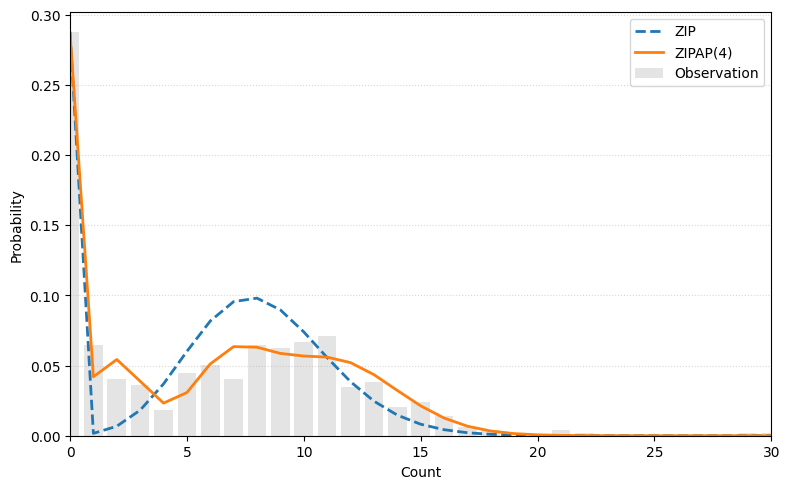

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# ---------------------------------------------------
# 0) 준비: 그리드와 관측 히스토그램
# ---------------------------------------------------
y_max = 30
y = np.arange(0, y_max + 1)

# 관측 데이터 밀도 히스토그램
hist_vals, _ = np.histogram(
    y_all,
    bins=np.arange(-0.5, y_max + 1.5, 1),
    density=True
)

# ---------------------------------------------------
# 1) ZIP 모델 (degree=0) PMF
# ---------------------------------------------------
zip_model = best_results[0]["model"]
pmf_zip = compute_model_pmf(zip_model, y)

# ---------------------------------------------------
# 2) ZIPAP(4) – regression 파라미터 기반 PMF
# ---------------------------------------------------
pmf_reg4 = compute_model_pmf(best_results[4]["model"], y)

# ---------------------------------------------------
# 3) ZIPAP(4) – 절편만 고정(π,λ,α) PMF
# ---------------------------------------------------
β4, γ4, u4, v4, lam_vec4, pi_vec4 = best_results[4]["model"].get_params()
lam_bar = np.exp(β4[0])
pi_bar  = 1.0 / (1.0 + np.exp(-γ4[0]))
alpha_vec = compute_alpha_from_uv(u4, v4)
Z_bar = sum(alpha_vec[j] * poisson_raw_moment(j, lam_bar) for j in range(len(alpha_vec)))

pmf_fix4 = np.zeros_like(y, float)
for idx, yv in enumerate(y):
    # T(y)
    T_y = np.polyval(list(reversed(alpha_vec)), yv)
    poi = poisson.pmf(yv, lam_bar)
    Pstar = T_y * poi / Z_bar
    pmf_fix4[idx] = (pi_bar + (1-pi_bar)*Pstar) if yv == 0 else (1-pi_bar)*Pstar

# ---------------------------------------------------
# 4) Poisson(λ=10) PMF
# ---------------------------------------------------
pmf_p10 = poisson.pmf(y, mu=10)

# ---------------------------------------------------
# 5) 플롯: 히스토그램 + 4개 모델 곡선
# ---------------------------------------------------
plt.figure(figsize=(8, 5))

# Observed histogram
plt.bar(
    y, hist_vals,
    width=0.8, color="lightgray", alpha=0.6,
    label="Observation"
)

# ZIP
plt.plot(y, pmf_zip,
         linestyle="--", linewidth=2, color="C0",
         label="ZIP")

# ZIPAP(4) regression hist_valspmf_reg4
plt.plot(y, pmf_reg4,
         linestyle="-", linewidth=2, color="C1",
         label="ZIPAP(4)")

# ZIPAP(4) fixed π,λ,α
# plt.plot(y, pmf_fix4,
#          linestyle="-.", linewidth=2, color="C2",
#          label="ZIPAP(4) fixed π,λ,α")

plt.xlim(0, 30)
plt.xlabel("Count")
plt.ylabel("Probability")
plt.legend(loc="upper right")
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

In [7]:
# hist_vals pmf_reg4
diff_real_zip = hist_vals - pmf_zip
diff_real_zipap = hist_vals - pmf_reg4

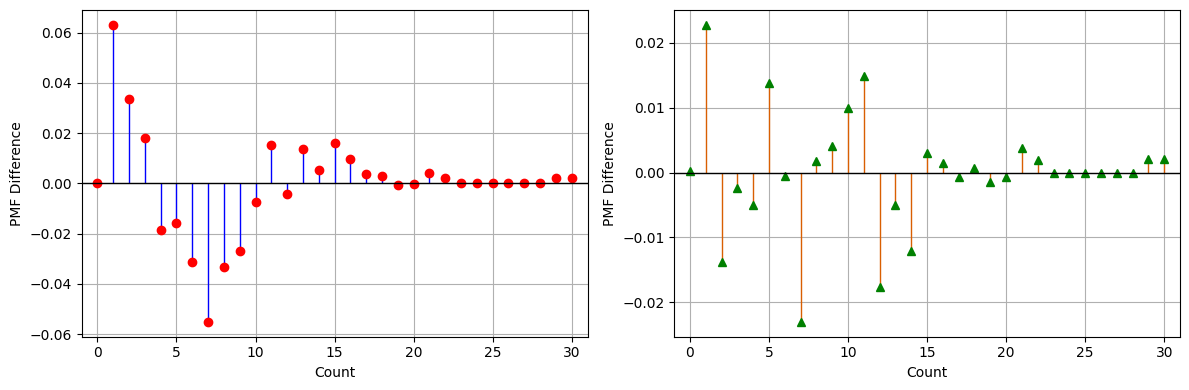

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1. y grid 설정
y_max = 30
y_grid = np.arange(0, y_max + 1)

# 2. 관측 PMF (히스토그램 기반)
hist_vals, _ = np.histogram(
    y_all, bins=np.arange(-0.5, y_max + 1.5, 1), density=True
)

# 3. 차이 계산 (ZIP, ZIPAP 모델 각각)
diff_real_zip = hist_vals - pmf_zip        # ZIP과의 차이
diff_real_zipap = hist_vals - pmf_reg4     # ZIPAP(4)과의 차이

# ---------- 서브플롯 구성 ----------
fig, (axL, axR) = plt.subplots(1, 2, figsize=(12, 4))

# ---------- 좌측: ZIP vs Observed ----------
axL.vlines(y_grid, 0, diff_real_zip, color='blue', linewidth=1)
axL.plot(y_grid, diff_real_zip, 'ro', markersize=6)
axL.axhline(0, color='black', linewidth=1)
axL.set_xlim(-1, y_max + 1)
axL.set_xlabel("Count")
axL.set_ylabel("PMF Difference")
axL.grid(True)

# ---------- 우측: ZIPAP(4) vs Observed ----------
axR.vlines(y_grid, 0, diff_real_zipap, color='#d95f02', linewidth=1)
axR.plot(y_grid, diff_real_zipap, 'g^', markersize=6)
axR.axhline(0, color='black', linewidth=1)
axR.set_xlim(-1, y_max + 1)
axR.set_xlabel("Count")
axR.set_ylabel("PMF Difference")
axR.grid(True)

# ---------- 전체 레이아웃 정리 ----------
plt.tight_layout()
plt.show()


Degree 0: alpha = [1.]
Degree 1: alpha = [1. 0.]
Degree 2: alpha = [1.e+00 7.e-06 0.e+00]
Degree 3: alpha = [ 1.00000e+00 -2.95855e-01  2.37510e-02  1.00000e-06]
Degree 4: alpha = [ 1.00000e+00 -6.42773e-01  1.52509e-01 -1.54630e-02  5.84000e-04]


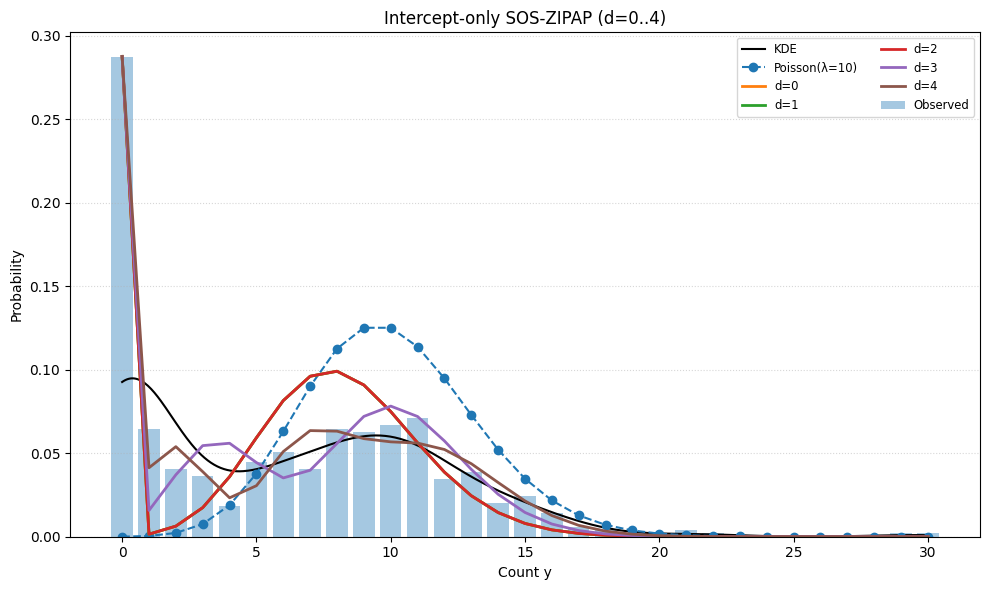

In [69]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson, gaussian_kde
from functools import lru_cache

# ============================================================
# 1) 데이터 로드 및 준비 (공변량 완전 무시)
#    fish DataFrame이 이미 메모리에 있다고 가정합니다.
# ============================================================
y_fish = fish["count"].astype(int).values
np.random.seed(42)
y_p10 = np.random.poisson(lam=10, size=y_fish.shape[0])
y_comb = np.concatenate([y_fish, y_p10])
mask   = y_comb <= 30
y_all  = y_comb[mask]
n      = len(y_all)

# ============================================================
# 2) 디자인 행렬: 절편(intercept)만 사용
# ============================================================
X = np.ones((n, 1))  # λ 모델용 intercept-only
Z = np.ones((n, 1))  # π 모델용 intercept-only

# ============================================================
# 3) Poisson raw-moment & α 계산 헬퍼
# ============================================================
@lru_cache(None)
def _S(n, k):
    if n == k == 0: return 1
    if n == 0 or k == 0 or k > n: return 0
    return _S(n-1, k-1) + k * _S(n-1, k)

def poisson_raw_moment(j, lam):
    lam_arr = np.atleast_1d(lam).astype(float)
    if j == 0:
        res = np.ones_like(lam_arr)
    elif j == 1:
        res = lam_arr
    elif j == 2:
        res = lam_arr**2 + lam_arr
    elif j == 3:
        res = lam_arr**3 + 3*lam_arr**2 + lam_arr
    else:
        res = np.zeros_like(lam_arr)
        for k in range(j+1):
            res += _S(j, k) * lam_arr**k
    return res if res.size > 1 else res[0]

def compute_alpha_from_uv(u, v):
    r0, r1 = len(u)-1, len(v)-1
    d = max(2*r0, 1 + 2*r1)
    alpha = np.zeros(d+1)
    alpha[0] = 1.0
    for i in range(r0+1):
        for j in range(r0+1):
            if i==0 and j==0: continue
            alpha[i+j] += u[i]*u[j]
    for p in range(r1+1):
        for q in range(r1+1):
            alpha[p+q+1] += v[p]*v[q]
    return alpha

# ============================================================
# 4) SOS-ZIPAP 인터셉트 전용 클래스 (degree d)
# ============================================================
class ZIPAP_SoS_ID:
    def __init__(self, degree: int):
        self.r0 = degree // 2
        self.r1 = (degree - 1) // 2 if degree > 0 else -1
        # parameters: beta0, gamma0, u1..u_r0, v0..v_r1
        size = 2 + self.r0 + max(self.r1+1, 0)
        self.theta = np.zeros(size)

    def _unpack(self, theta):
        beta0 = theta[0]
        gamma0 = theta[1]
        u = np.concatenate(([1.0], theta[2:2+self.r0])) if self.r0 > 0 else np.array([1.0])
        v = theta[2+self.r0:2+self.r0+(self.r1+1)] if self.r1 >= 0 else np.array([])
        return beta0, gamma0, u, v

    def neg_loglik(self, theta, y):
        beta0, gamma0, u, v = self._unpack(theta)
        lam0 = np.exp(beta0)
        pi0  = 1/(1 + np.exp(-gamma0))
        alpha = compute_alpha_from_uv(u, v)
        Znorm = sum(alpha[j] * poisson_raw_moment(j, lam0) for j in range(len(alpha)))
        ll = 0.0
        for yi in y:
            s0 = sum(u[k] * yi**k for k in range(len(u)))
            T  = s0**2
            if v.size > 0:
                s1 = sum(v[k] * yi**k for k in range(len(v)))
                T += yi * (s1**2)
            if yi == 0:
                p = pi0 + (1-pi0)*(T * poisson.pmf(yi, lam0) / Znorm)
            else:
                p = (1-pi0)*(T * poisson.pmf(yi, lam0) / Znorm)
            ll += np.log(p + 1e-16)
        return -ll

    def fit(self, y, maxiter=500):
        theta0 = np.zeros_like(self.theta)
        nz = y[y>0]
        theta0[0] = np.log(np.mean(nz)) if nz.size > 0 else 0
        zero_rate = (y == 0).mean()
        theta0[1] = np.log(zero_rate/(1-zero_rate)) if zero_rate < 1 else 0
        res = minimize(self.neg_loglik, theta0, args=(y,), method='L-BFGS-B', options={'maxiter':maxiter})
        self.theta = res.x
        return res

    def get_params(self):
        return self._unpack(self.theta)

# ============================================================
# 5) degree=0..4 모델 학습 및 α 출력
# ============================================================
best_models = []
for d in range(5):  # degrees 0 to 4
    model = ZIPAP_SoS_ID(d)
    model.fit(y_all)
    beta0, gamma0, u, v = model.get_params()
    alpha = compute_alpha_from_uv(u, v)
    print(f"Degree {d}: alpha = {np.round(alpha, 6)}")
    best_models.append((d, model))

# ============================================================
# 6) intercept-only PMF 계산 및 플롯
# ============================================================
y_max  = 30
y_grid = np.arange(y_max+1)

# Observed histogram & KDE
hist, _ = np.histogram(y_all, bins=np.arange(-0.5, y_max+1.5, 1), density=True)
kde = gaussian_kde(y_all)
y_kde = np.linspace(0, y_max, 500)

plt.figure(figsize=(10, 6))
plt.bar(y_grid, hist, width=0.8, alpha=0.4, label='Observed')
plt.plot(y_kde, kde(y_kde), 'k-', lw=1.5, label='KDE')
plt.plot(y_grid, poisson.pmf(y_grid, 10), '--o', label='Poisson(λ=10)')

for d, model in best_models:
    beta0, gamma0, u, v = model.get_params()
    lam0 = np.exp(beta0)
    pi0  = 1/(1 + np.exp(-gamma0))
    alpha = compute_alpha_from_uv(u, v)
    Znorm = sum(alpha[j] * poisson_raw_moment(j, lam0) for j in range(len(alpha)))
    pmf = []
    for yi in y_grid:
        s0 = sum(u[k] * yi**k for k in range(len(u)))
        T  = s0**2
        if v.size > 0:
            s1 = sum(v[k] * yi**k for k in range(len(v)))
            T += yi * (s1**2)
        if yi == 0:
            p = pi0 + (1-pi0)*(T * poisson.pmf(yi, lam0) / Znorm)
        else:
            p = (1-pi0)*(T * poisson.pmf(yi, lam0) / Znorm)
        pmf.append(p)
    plt.plot(y_grid, pmf, lw=2, label=f'd={d}')

plt.xlabel('Count y')
plt.ylabel('Probability')
plt.title('Intercept-only SOS-ZIPAP (d=0..4)')
plt.legend(fontsize='small', ncol=2)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


Degree 0: beta0 = 2.110293, gamma0 = -0.907867, alpha = [1.]
Degree 1: beta0 = 2.110293, gamma0 = -0.907867, alpha = [1. 0.]
Degree 2: beta0 = 2.110289, gamma0 = -0.908713, alpha = [1.e+00 7.e-06 0.e+00]
Degree 3: beta0 = 1.918144, gamma0 = -0.923384, alpha = [ 1.00000e+00 -2.95855e-01  2.37510e-02  1.00000e-06]
Degree 4: beta0 = 1.816435, gamma0 = -0.974844, alpha = [ 1.00000e+00 -6.42773e-01  1.52509e-01 -1.54630e-02  5.84000e-04]


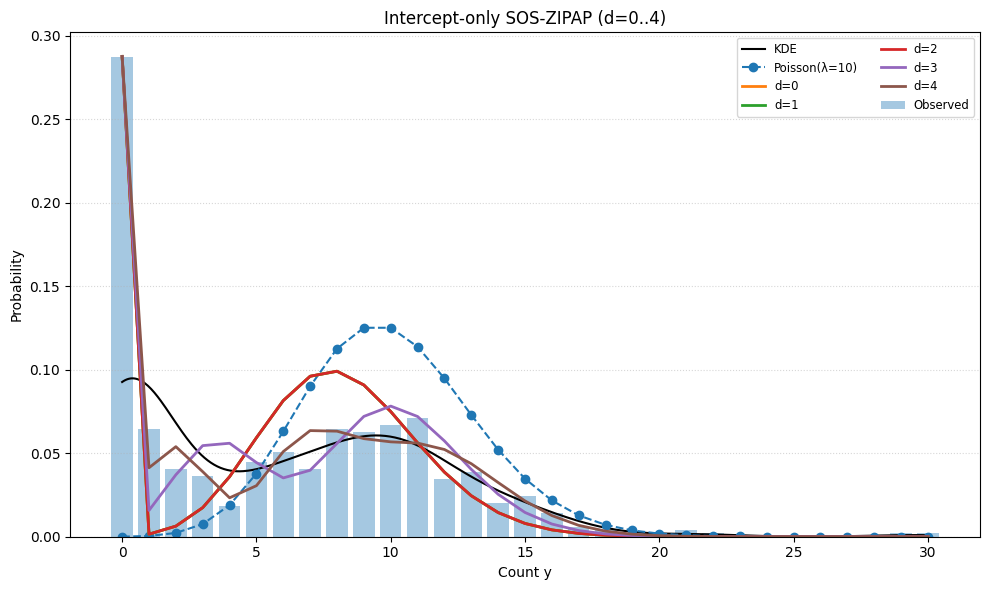

In [70]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson, gaussian_kde
from functools import lru_cache

# ============================================================
# 5) degree=0..4 모델 학습 및 계수(beta0, gamma0, alpha) 출력
# ============================================================
best_models = []
for d in range(5):  # degrees 0 to 4
    model = ZIPAP_SoS_ID(d)
    model.fit(y_all)
    beta0, gamma0, u, v = model.get_params()
    alpha = compute_alpha_from_uv(u, v)
    print(f"Degree {d}: beta0 = {beta0:.6f}, gamma0 = {gamma0:.6f}, alpha = {np.round(alpha, 6)}")
    best_models.append((d, model))

# ============================================================
# 6) intercept-only PMF 계산 및 플롯
# ============================================================

y_max  = 30
y_grid = np.arange(y_max+1)

# Observed histogram & KDE
hist, _ = np.histogram(y_all, bins=np.arange(-0.5, y_max+1.5, 1), density=True)
kde = gaussian_kde(y_all)
y_kde = np.linspace(0, y_max, 500)

plt.figure(figsize=(10, 6))
plt.bar(y_grid, hist, width=0.8, alpha=0.4, label='Observed')
plt.plot(y_kde, kde(y_kde), 'k-', lw=1.5, label='KDE')
plt.plot(y_grid, poisson.pmf(y_grid, 10), '--o', label='Poisson(λ=10)')

for d, model in best_models:
    beta0, gamma0, u, v = model.get_params()
    lam0 = np.exp(beta0)
    pi0  = 1/(1 + np.exp(-gamma0))
    alpha = compute_alpha_from_uv(u, v)
    Znorm = sum(alpha[j] * poisson_raw_moment(j, lam0) for j in range(len(alpha)))
    pmf = []
    for yi in y_grid:
        s0 = sum(u[k] * yi**k for k in range(len(u)))
        T  = s0**2
        if v.size > 0:
            s1 = sum(v[k] * yi**k for k in range(len(v)))
            T += yi * (s1**2)
        if yi == 0:
            p = pi0 + (1-pi0)*(T * poisson.pmf(yi, lam0) / Znorm)
        else:
            p = (1-pi0)*(T * poisson.pmf(yi, lam0) / Znorm)
        pmf.append(p)
    plt.plot(y_grid, pmf, lw=2, label=f'd={d}')

plt.xlabel('Count y')
plt.ylabel('Probability')
plt.title('Intercept-only SOS-ZIPAP (d=0..4)')
plt.legend(fontsize='small', ncol=2)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

d=0, λ=8.251, logLik=-1164.13, AIC=2330.26, MSE=0.0009, α=[1.]
d=1, λ=8.251, logLik=-1164.13, AIC=2332.26, MSE=0.0009, α=[1. 0.]
d=2, λ=8.248, logLik=-1164.13, AIC=2334.26, MSE=0.0009, α=[1. 0. 0.]
d=3, λ=6.831, logLik=-1054.19, AIC=2116.39, MSE=0.0004, α=[ 1.    -0.293  0.023  0.   ]
d=4, λ=6.462, logLik=-1026.50, AIC=2063.00, MSE=0.0002, α=[ 1.    -0.599  0.133 -0.013  0.   ]
d=5, λ=6.447, logLik=-1026.49, AIC=2064.99, MSE=0.0002, α=[ 1.    -0.597  0.132 -0.012  0.     0.   ]


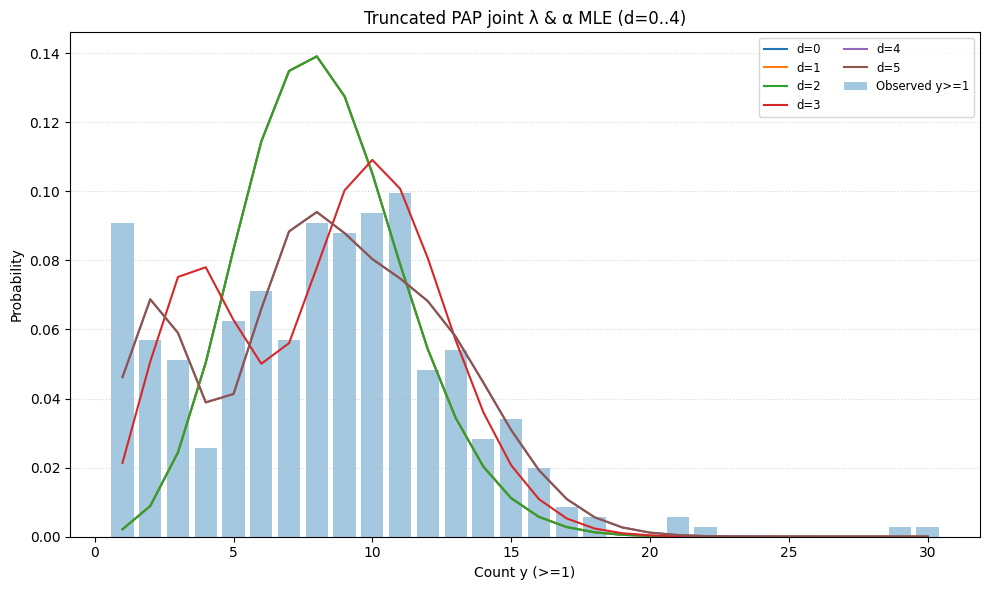

In [97]:

#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson
from functools import lru_cache

# ============================================================
# Pure PAP: Joint λ & α Estimation on y>=1 (Truncated at zero)
# Implements proper zero-truncation for y>=1 support
# θ = (logλ, u1..u_r0, v0..v_r1)
# ============================================================

# 1) 데이터 준비: fish['count'] 및 합성
counts = fish['count'].astype(int).values
rng = np.random.RandomState(42)
y_p10 = rng.poisson(lam=10, size=len(counts))
# y>=1, y<=30 필터
y_all = np.concatenate([counts, y_p10])
y_all = y_all[(y_all >= 1) & (y_all <= 30)]

# 2) Poisson raw-moment & α 계산 헬퍼
@lru_cache(None)
def _S(n, k):
    if n == k == 0: return 1
    if n == 0 or k == 0 or k > n: return 0
    return _S(n-1, k-1) + k * _S(n-1, k)

def poisson_raw_moment(j, lam):
    lam = np.asarray(lam, float)
    if j == 0: return np.ones_like(lam)
    if j == 1: return lam
    if j == 2: return lam**2 + lam
    if j == 3: return lam**3 + 3*lam**2 + lam
    out = np.zeros_like(lam)
    for k in range(j+1): out += _S(j, k) * lam**k
    return out

def compute_alpha(u, v):
    r0, r1 = len(u)-1, len(v)-1
    d = max(2*r0, 1 + 2*r1)
    alpha = np.zeros(d+1)
    alpha[0] = 1.0
    for i in range(r0+1):
        for j in range(r0+1):
            if i==0 and j==0: continue
            alpha[i+j] += u[i]*u[j]
    for p in range(r1+1):
        for q in range(r1+1): alpha[p+q+1] += v[p]*v[q]
    return alpha

# 3) Joint-MLE with zero-truncated support
def truncated_loglik(theta, y, r0, r1):
    # unpack
    loglam = theta[0]
    lam = np.exp(loglam)
    u1 = theta[1:1+r0]
    v  = theta[1+r0:]
    u = np.concatenate(([1.0], u1))
    # compute α and normalization Z_full
    alpha = compute_alpha(u, v)
    Z_full = sum(alpha[j]*poisson_raw_moment(j, lam) for j in range(len(alpha)))
    # compute mass at zero
    P0 = poisson.pmf(0, lam)  # with T(0)=1 always
    # truncated normalization factor
    denom = 1 - P0
    # log-likelihood
    ll = 0.0
    for yi in y:
        # T(yi)
        T = u.dot([yi**k for k in range(len(u))])**2
        if len(v)>0:
            T += yi * (v.dot([yi**k for k in range(len(v))])**2)
        p_star = T * poisson.pmf(yi, lam) / Z_full
        # truncated pmf
        p = p_star / denom
        ll += np.log(p + 1e-16)
    return -ll

class PAP_MLE_Trunc:
    def __init__(self, degree, y):
        self.r0 = degree//2
        self.r1 = (degree-1)//2 if degree>0 else -1
        self.npar = 1 + self.r0 + max(self.r1+1,0)
        self.theta = np.zeros(self.npar)
        self.y = y

    def fit(self):
        res = minimize(truncated_loglik, self.theta,
                       args=(self.y, self.r0, self.r1),
                       method='L-BFGS-B')
        if not res.success:
            raise RuntimeError(res.message)
        self.theta = res.x
        return res

    def pmf(self, y):
        lam, u1, v = np.exp(self.theta[0]), self.theta[1:1+self.r0], self.theta[1+self.r0:]
        u = np.concatenate(([1.0], u1))
        alpha = compute_alpha(u, v)
        Z_full = sum(alpha[j]*poisson_raw_moment(j, lam) for j in range(len(alpha)))
        denom = 1 - poisson.pmf(0, lam)
        T = u.dot([y**k for k in range(len(u))])**2
        if len(v)>0:
            T += y * (v.dot([y**k for k in range(len(v))])**2)
        p_star = T * poisson.pmf(y, lam) / Z_full
        return p_star / denom

# 4) Fit models, output & evaluate (logLik, AIC, MSE)
models = {}
results = []
# precompute observed frequencies for MSE
y_grid = np.arange(1,31)
hist, _ = np.histogram(y_all, bins=np.arange(0.5,31.5,1), density=True)

for d in range(6):
    mdl = PAP_MLE_Trunc(degree=d, y=y_all)
    res = mdl.fit()
    models[d] = mdl
    # log-likelihood
    ll = -truncated_loglik(mdl.theta, y_all, mdl.r0, mdl.r1)
    # number of parameters
    K = mdl.npar
    # AIC
    AIC = 2*K - 2*ll
    # MSE between observed histogram and model pmf
    pmf_vals = np.array([mdl.pmf(yi) for yi in y_grid])
    mse = np.mean((hist - pmf_vals)**2)
    # parameter estimates
    lam = np.exp(mdl.theta[0])
    alpha = compute_alpha(np.concatenate(([1.0], mdl.theta[1:1+mdl.r0])), mdl.theta[1+mdl.r0:])
    print(f"d={d}, λ={lam:.3f}, logLik={ll:.2f}, AIC={AIC:.2f}, MSE={mse:.4f}, α={np.round(alpha,3)}")
    results.append({
        'degree': d,
        'lambda': lam,
        'logLik': ll,
        'AIC': AIC,
        'MSE': mse,
        'alpha': alpha
    })

# 5) Plot on support y>=1
plt.figure(figsize=(10,6))
plt.bar(y_grid, hist, width=0.8, alpha=0.4, label='Observed y>=1')
for d, m in models.items():
    pmf_vals = [m.pmf(yi) for yi in y_grid]
    plt.plot(y_grid, pmf_vals, label=f'd={d}')
plt.xlabel('Count y (>=1)')
plt.ylabel('Probability')
plt.title('Truncated PAP joint λ & α MLE (d=0..4)')
plt.legend(fontsize='small', ncol=2)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()
y_grid = np.arange(1,31)
hist, _ = np.histogram(y_all, bins=np.arange(0.5,31.5,1), density=True)

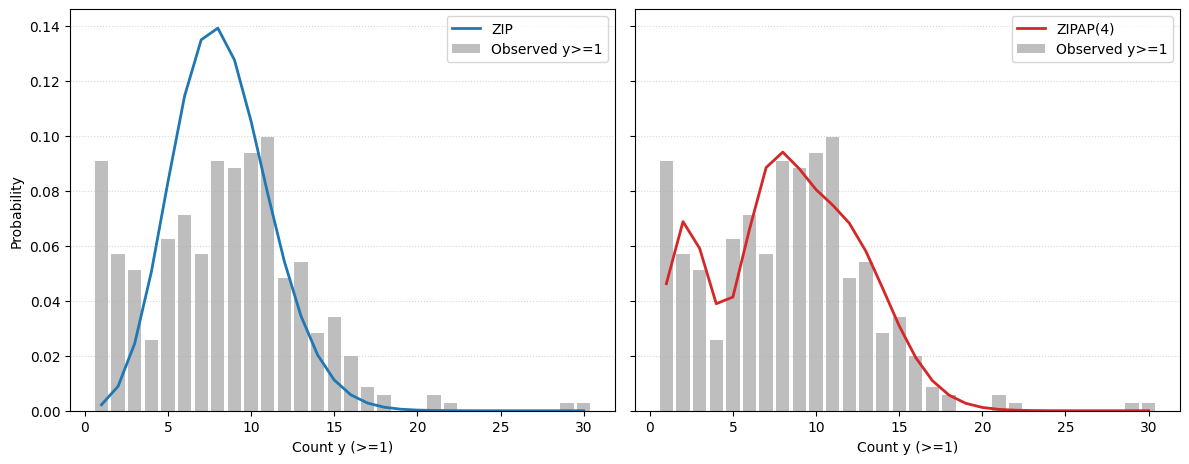

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = {0: 'C0', 4: 'C3'}
for ax, d in zip(axes, [0, 4]):

    # 관측값 색상 지정: 오른쪽(d=4)만 다르게
    obs_color = 'C7' 
    ax.bar(y_grid, hist, width=0.8, alpha=0.5, label='Observed y>=1', color=obs_color)
    
    # 모델 PMF
    pmf_vals = [models[d].pmf(yi) for yi in y_grid]
    label = 'ZIP' if d == 0 else f'ZIPAP({d})'
    ax.plot(
        y_grid,
        pmf_vals,
        label=label,
        color=colors[d],
        linewidth=2
    )
    ax.set_xlabel('Count y (>=1)')
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    if ax is axes[0]:
        ax.set_ylabel('Probability')
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

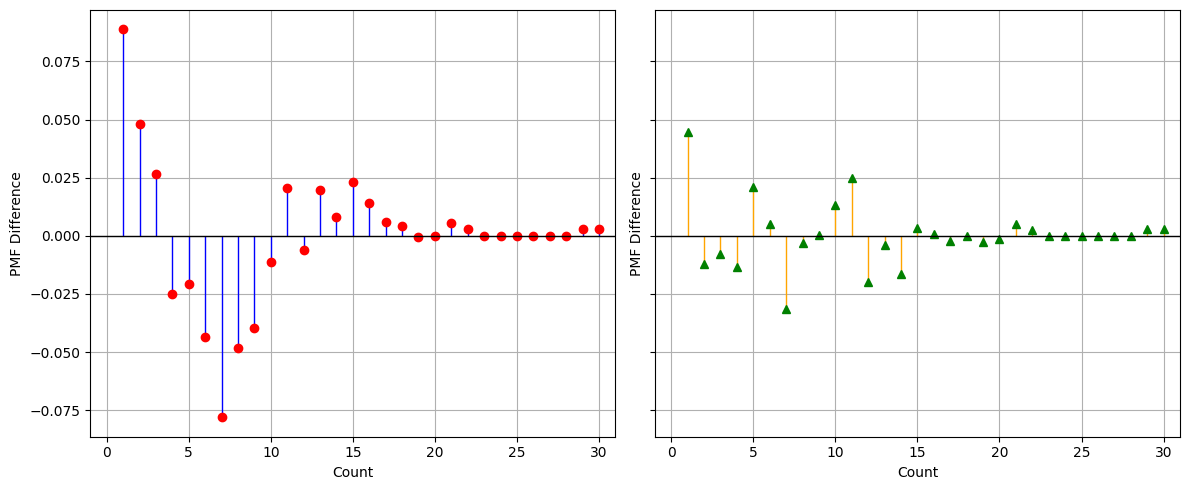

In [127]:
pmf0 = np.array([models[0].pmf(yi) for yi in y_grid])

pmf4 = np.array([models[4].pmf(yi) for yi in y_grid])

diff_4 = hist - pmf4
diff_0 = hist - pmf0

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].vlines(y_grid, 0, diff_0, color='blue', linewidth=1)
axs[0].plot(y_grid, diff_0, 'ro', markersize=6)
axs[0].axhline(0, color='black', linewidth=1)
axs[0].set_xlim(-1, y_max + 1)
axs[0].set_xlabel("Count")
axs[0].set_ylabel("PMF Difference")
axs[0].grid(True)

axs[1].vlines(y_grid, 0, diff_4, color='orange', linewidth=1)
axs[1].plot(y_grid, diff_4, 'g^', markersize=6)
axs[1].axhline(0, color='black', linewidth=1)
axs[1].set_xlim(-1, y_max + 1)
axs[1].set_xlabel("Count")
axs[1].set_ylabel("PMF Difference")
axs[1].grid(True)
plt.tight_layout()


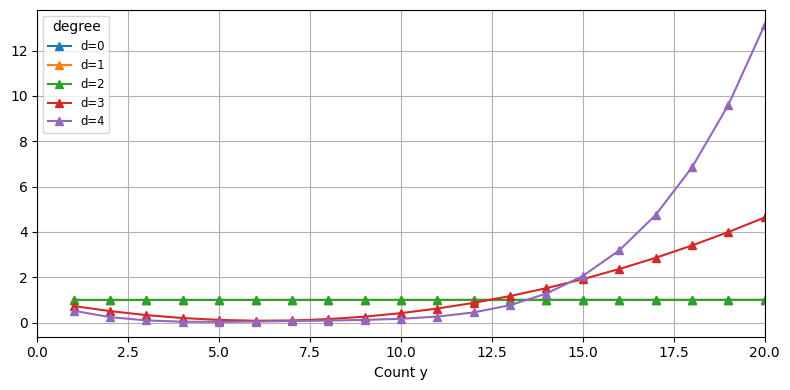

In [133]:
# 8) Polynomial Adjusters T(y;α) for degrees 0 to 4 (0 ≤ y ≤ 20)
plt.figure(figsize=(8, 4))
maskR = y_grid <= 20
# Loop through results entries limited to degrees 0..4
for entry in results:
    d = entry['degree']
    if d > 4:
        continue
    α_hat = entry['alpha']
    # T(y) = Σ_{j=0}^d α_j * y^j
    T_vals = sum(α_hat[j] * y_grid**j for j in range(len(α_hat)))
    plt.plot(
        y_grid[maskR],
        T_vals[maskR],
        label=f'd={d}',
        marker='^',
        linestyle='-'
    )
plt.xlabel('Count y')
plt.xlim(0, 20)
plt.legend(title='degree', fontsize='small', ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()



# MSE 값 생성하기

In [23]:
pmf_reg0 = compute_model_pmf(best_results[0]["model"], y)
pmf_reg1= compute_model_pmf(best_results[1]["model"], y)
pmf_reg2 = compute_model_pmf(best_results[2]["model"], y)
pmf_reg3 = compute_model_pmf(best_results[3]["model"], y)
pmf_reg4 = compute_model_pmf(best_results[4]["model"], y)

In [ ]:
# MSE 계산 방법
from sklearn.metrics import mean_squared_error

print(f"ZIPAP(0) : {np.round(mean_squared_error(hist_vals, pmf_reg0),6)}")
print(f"ZIPAP(1)  : {np.round(mean_squared_error(hist_vals, pmf_reg1),6)}")
print(f"ZIPAP(2)  : {np.round(mean_squared_error(hist_vals, pmf_reg2),6)}")
print(f"ZIPAP(3)  : {np.round(mean_squared_error(hist_vals, pmf_reg3),6)}")
print(f"ZIPAP(4)  : {np.round(mean_squared_error(hist_vals, pmf_reg4),6)}")

# single zipap

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import poisson

# ===========================
# 0) 데이터 로드 및 디자인 행렬 정의
# ===========================
# (A) fish DataFrame이 이미 로드되어 있는 상태라고 가정합니다.
# 예시: fish = pd.read_csv("your_fish_data.csv")

# 종속변수 y_int (정수형)
y_int = fish["count"].values.astype(int)

# 디자인 행렬 X (절편 + persons), Z (절편 + camper)
X = np.column_stack([np.ones(len(fish)), fish[["persons"]].values])
Z = np.column_stack([np.ones(len(fish)), fish[["camper"]].values])

# ===========================
# 1) ZIPAP 클래스 정의
# ===========================
class ZIPAP:
    """
    Zero-Inflated Poisson with Arbitrary Polynomial Adjustor (ZIPAP) 모델.
    d 차수에 따라 T(y) = Σ_{k=0}^d α_k y^k, α₀ = 1, α_k ≥ 0 (k>0).
    """
    def __init__(self, X, Z, degree=3, alpha_init_eps=1e-2):
        self.X = np.asarray(X)
        self.Z = np.asarray(Z)
        self.n, self.p = self.X.shape
        _, self.q = self.Z.shape
        self.d = degree

        # β(p), γ(q), α(d+1) 초기화
        self.beta  = np.zeros(self.p)
        self.gamma = np.zeros(self.q)
        # α₀ = 1, α₁..α_d = alpha_init_eps (>0)
        self.alpha = np.concatenate(([1.0], np.full(self.d, alpha_init_eps)))

    def _T(self, y):
        """
        T(y; α) = Σ_{k=0}^d α_k * y^k
        """
        y = np.asarray(y)
        powers = np.vstack([y**k for k in range(self.d + 1)])  # shape = (d+1, len(y))
        return np.dot(self.alpha, powers)

    def _Z(self, lam):
        """
        Z(λ; α) = E_{Y ∼ Pois(λ)}[T(Y; α)]
        d ≤ 4: closed-form Poisson raw moments 사용
        d > 4: truncate sum up to Ymax
        """
        lam = np.asarray(lam)
        if self.d <= 4:
            # Poisson raw moments 계산
            m0 = np.ones_like(lam)                      # E[Y^0]
            m1 = lam                                     # E[Y^1]
            m2 = lam**2 + lam                            # E[Y^2]
            m3 = lam**3 + 3*lam**2 + lam                 # E[Y^3]
            m4 = lam**4 + 6*lam**3 + 7*lam**2 + lam       # E[Y^4]
            Zval = self.alpha[0] * m0
            if self.d >= 1: Zval += self.alpha[1] * m1
            if self.d >= 2: Zval += self.alpha[2] * m2
            if self.d >= 3: Zval += self.alpha[3] * m3
            if self.d >= 4: Zval += self.alpha[4] * m4
            return Zval
        else:
            # d > 4: 수치적 truncation
            Ymax = max(30, int(np.max(lam) + 10 * self.d))
            ys = np.arange(Ymax + 1)
            pmf_vals = np.vstack([poisson.pmf(ys, lam_i) for lam_i in lam])  # (n, Ymax+1)
            T_vals   = np.vstack([self._T(ys) for _ in lam])                  # (n, Ymax+1)
            return np.sum(pmf_vals * T_vals, axis=1)

    def _pi_lambda(self):
        """
        π_i = sigmoid(Z_i γ), λ_i = exp(X_i β)
        """
        eta = self.Z.dot(self.gamma)
        pi  = 1.0 / (1.0 + np.exp(-eta))
        lam = np.exp(self.X.dot(self.beta))
        return pi, lam

    def pmf(self, y):
        """
        y: 각 관측치(정수) 벡터 → 현재 파라미터로 pmf 계산
          • y_i = 0: π_i + (1−π_i)·Pois(0;λ_i)·T(0)/Z(λ_i)
          • y_i > 0: (1−π_i)·Pois(y_i;λ_i)·T(y_i)/Z(λ_i)
        """
        y = np.asarray(y)
        assert self.X.shape[0] == len(y) == self.Z.shape[0], "X, Z, y 길이가 같아야 합니다."
        pi, lam = self._pi_lambda()
        T_y     = self._T(y)
        Z_l     = self._Z(lam)
        p       = np.zeros_like(y, dtype=float)

        mask0 = (y == 0)
        if np.any(mask0):
            p0_part = poisson.pmf(0, lam[mask0]) * T_y[mask0] / Z_l[mask0]
            p[mask0] = pi[mask0] + (1 - pi[mask0]) * p0_part

        mask_pos = (y > 0)
        if np.any(mask_pos):
            pmf_pos = poisson.pmf(y[mask_pos], lam[mask_pos]) * T_y[mask_pos] / Z_l[mask_pos]
            p[mask_pos] = (1 - pi[mask_pos]) * pmf_pos

        return p

    def log_lik(self, theta):
        """
        음의 로그우도 함수 (최소화 대상).
        θ = [β, γ, α[1..d]] 형태 → α[1..d]는 절댓값 → α_k ≥ 0
        """
        self.beta      = theta[:self.p]
        self.gamma     = theta[self.p:self.p + self.q]
        self.alpha[1:] = np.abs(theta[self.p + self.q:])
        y = self._y
        pmf_vals = self.pmf(y)
        pmf_vals = np.clip(pmf_vals, 1e-12, None)
        return -np.sum(np.log(pmf_vals))

    def init_moments(self, y, alpha_init_eps=None):
        """
        Method-of-Moments 초기값.
        μ = mean(y), var = var(y), π₀ ≈ 1 - var/μ, λ₀ = μ/(1 - π₀)
        γ₀ = logit(π₀), 나머지 γ = 0
        β ≈ log(λ₀) - log(mean(X 열))
        α = [1, α_init_eps, …, α_init_eps]
        """
        y = np.asarray(y)
        mu  = np.mean(y)
        var = np.var(y)
        pi0 = np.clip(1 - var / mu, 1e-3, 1 - 1e-3)
        lam0 = mu / (1 - pi0)
        self.gamma = np.array([np.log(pi0 / (1 - pi0))] + [0]*(self.q - 1))
        X_means = np.mean(self.X, axis=0)
        self.beta = np.log(lam0) - np.log(X_means)
        if alpha_init_eps is not None:
            self.alpha = np.concatenate(([1.0], np.full(self.d, alpha_init_eps)))

    def to_theta(self):
        return np.concatenate([self.beta, self.gamma, self.alpha[1:]])

    def fit(self, y, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1):
        """
        y: 관측치(정수형) 벡터
        α 초깃값(initial_alpha_eps) → 실패 시 retry_alpha_eps → 실패 시 Nelder-Mead
        β, γ unconstrained, α[1..d] ≥ 0 (bounds)
        """
        self._y = np.asarray(y)
        self.init_moments(y, alpha_init_eps=initial_alpha_eps)
        theta0 = self.to_theta()
        bounds = [(None, None)]*(self.p + self.q) + [(0, None)]*self.d

        res = opt.minimize(self.log_lik, theta0, method=method, bounds=bounds)
        if not res.success:
            # 1차 실패 → α초깃값 키워서 재시도
            self.init_moments(y, alpha_init_eps=retry_alpha_eps)
            theta0_retry = self.to_theta()
            res_retry = opt.minimize(self.log_lik, theta0_retry, method=method, bounds=bounds)
            if res_retry.success:
                res = res_retry
            else:
                # 2차 실패 → Nelder-Mead
                self.init_moments(y, alpha_init_eps=retry_alpha_eps)
                theta0_nm = self.to_theta()
                res_nm = opt.minimize(self.log_lik, theta0_nm, method='Nelder-Mead')
                if not res_nm.success:
                    raise RuntimeError(f"Nelder-Mead도 실패: {res_nm.message}")
                res = res_nm

        # 최종 파라미터 반영
        self.beta      = res.x[:self.p]
        self.gamma     = res.x[self.p:self.p + self.q]
        self.alpha[1:] = np.abs(res.x[self.p + self.q:])
        return res

    def predict_mean(self):
        pi, lam = self._pi_lambda()
        return (1 - pi) * lam

    def aic(self):
        k = self.p + self.q + self.d
        return 2*k + 2*self.log_lik(self.to_theta())

    def bic(self):
        k = self.p + self.q + self.d
        return np.log(self.n)*k + 2*self.log_lik(self.to_theta())

In [131]:
# 종속변수: 정수형 count
y_int = fish["count"].values.astype(int)

# 디자인 행렬 정의
#  - X: count component (절편 + persons)
#  - Z: zero-inflation component (절편 + camper)
X = np.column_stack([
    np.ones(len(fish)),
    fish[["persons"]].values
])
Z = np.column_stack([
    np.ones(len(fish)),
    fish[["camper"]].values
])


In [ ]:
# 1. ZIP 모델 추정
from statsmodels.discrete.count_model import ZeroInflatedPoisson

zip_model = ZeroInflatedPoisson(endog=y_int, exog=X, exog_infl=Z, inflation='logit')
zip_result = zip_model.fit()

zip_result.summary()

In [ ]:
ys = np.arange(0, np.max(y_int) + 1)

# 1. 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=len(ys))
obs_probs = obs_counts / obs_counts.sum()

# 2. ZIP 평균 예측 분포
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)  # shape: (n_samples, n_counts)
zip_probs_avg = np.mean(zip_probs, axis=0)

# 1. 회귀 계수 β 추출 (exog는 count model)
beta_hat = zip_result.params[:X.shape[1]]

# 2. 각 관측치의 λᵢ 계산
lambda_hat = np.exp(X @ beta_hat)

# 3. 평균 λ
lambda_mean = np.mean(lambda_hat)
print(f"Poisson Mean (λ) from ZIP model: {lambda_mean:.4f}")


In [ ]:
ys = np.arange(0, np.max(y_int) + 1)

# 1. 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=len(ys))
obs_probs = obs_counts / obs_counts.sum()

# 2. ZIP 평균 예측 분포
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)  # shape: (n_samples, n_counts)
zip_probs_avg = np.mean(zip_probs, axis=0)

# 1. 회귀 계수 β 추출 (exog는 count model)
beta_hat = zip_result.params[:X.shape[1]]

# 2. 각 관측치의 λᵢ 계산
lambda_hat = np.exp(X @ beta_hat)

# 3. 평균 λ
lambda_mean = np.mean(lambda_hat)
print(f"Poisson Mean (λ) from ZIP model: {lambda_mean:.4f}")

pi_hat = np.mean(zip_probs[:, 0])
print(f"Zero Probability (π) from ZIP model: {pi_hat:.4f}")



In [ ]:
def compute_predicted_zero_zipap(model, X, Z):
    model.X = X
    model.Z = Z
    pi, lam = model._pi_lambda()
    T0 = model._T(np.array([0]))
    Z_lam = model._Z(lam)
    p_zero = pi + (1 - pi) * poisson.pmf(0, lam) * T0 / Z_lam
    return np.mean(p_zero)

degrees = [0, 1, 2, 3]

for d in degrees:
    model = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-1)
    model.fit(y_int, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)

    # 예측된 Zero 비율
    pred_zero_rate = compute_predicted_zero_zipap(model, X, Z)

    # Poisson 평균 (λᵢ의 평균)
    _, lambda_hat = model._pi_lambda()
    poisson_mean = np.mean(lambda_hat)

    print(f"ZIPAP({d}): Predicted Zero Rate = {pred_zero_rate:.4f}, Poisson Mean = {poisson_mean:.4f}")

In [ ]:
# y_all: 관측값 벡터 (예: y_all = np.array([...]))
pi_obs = np.mean(y_int == 0)
print(f"Observed Zero Rate (π̂): {pi_obs:.4f}")

lambda_obs = np.mean(y_int)
print(f"Observed Poisson Mean (λ̂): {lambda_obs:.4f}")

In [ ]:
ys = np.arange(0, np.max(y_int) + 1)

# 1. 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=len(ys))
obs_probs = obs_counts / obs_counts.sum()

# 2. ZIP 평균 예측 분포
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)  # shape: (n_samples, n_counts)
zip_probs_avg = np.mean(zip_probs, axis=0)

# 1. 회귀 계수 β 추출 (exog는 count model)
beta_hat = zip_result.params[:X.shape[1]]

# 2. 각 관측치의 λᵢ 계산
lambda_hat = np.exp(X @ beta_hat)

# 3. 평균 λ
lambda_mean = np.mean(lambda_hat)
print(f"Poisson Mean (λ) from ZIP model: {lambda_mean:.4f}")


In [ ]:
plt.figure(figsize=(10, 6))
counts = np.arange(0, 30)  # 0~50 범위로 설정
# (5.1) Observed Empirical (회색 막대)
plt.bar(
    counts,
    obs_counts,
    color="gray",
    alpha=0.5,
    label="Observed Empirical (0~50)"
)

# (5.2) ZIPAP 곡선들 (파란, 빨강, 초록, 주황, 보라)
colors = {0: "blue", 1: "red", 2: "green", 3: "orange", 4: "purple"}
for degree in range(0, 5):
    if degree == 0:
        plt.plot(zip_probs_avg, label="ZIP", color="blue", linestyle='-', linewidth=2)
    else:
        label = f"ZIPAP K={degree}"
        # degree=0 은 표준 ZIP과 동일
        linestyle = '-' if degree == 0 else '--'
        plt.plot(
        counts,
        zipap_pmf[degree],
        label=label,
        color=colors[degree],
        linestyle=linestyle,
        linewidth=2
        )

plt.xlim(0, max_plot)
plt.xlabel("Count")
plt.ylabel("Probability")
plt.title("Observed vs Fitted PMF (ZIPAP K=0..4, 0~50)")
plt.legend()
plt.grid(True)
plt.show()